## Feature Importance Plot 

In [4]:
from sklearn.externals import joblib
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

In [8]:
def xgb_data_prep():
    basic_feat = pd.read_csv('feat_input/basic_feat.csv')
    longtime_feat = pd.read_csv('feat_input/longtime_feat.csv')
    encoded_feat = pd.read_csv('feat_input/feat_encoding.csv')
    cv_feat_train = pd.read_csv('feat_input/train_gdy.csv')
    cv_feat_test = pd.read_csv('feat_input/test_gdy.csv')
    cv_feat = cv_feat_train.append(cv_feat_test)
    print('Loading features finished')

    # apply ordinal encoding to categorical feature
    categorical = ["display_address", "manager_id", "building_id", "street_address"]
    for f in categorical:
        if basic_feat[f].dtype == 'object':
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(basic_feat[f].values))
            basic_feat[f] = lbl.transform(list(basic_feat[f].values))

    all = basic_feat.merge(longtime_feat, on='listing_id')
    all = all.merge(encoded_feat, on='listing_id')
    all = all.merge(cv_feat, on='listing_id')

    train = all[all.interest_level != -1].copy()
    test = all[all.interest_level == -1].copy()
    y_train=train["interest_level"]

    train_num=train.shape[0]
    print('Ordinal encoding finished')
    

    dtm = CountVectorizer(stop_words='english', max_features=100)
    all_sparse = dtm.fit_transform(all["features"].values.astype('U'))
    print("Document-term matrix finished")

    x_train = train.drop(["interest_level","features"],axis=1)
    x_test = test.drop(["interest_level","features"],axis=1)
    
    all_feat = list(all.columns.values)
    dtm_feat = dtm.get_feature_names()

    return all_feat + dtm_feat


In [9]:
features = xgb_data_prep()

Loading features finished
Ordinal encoding finished
Document-term matrix finished


In [10]:
features

['bathrooms',
 'bedrooms',
 'building_id',
 'display_address',
 'features',
 'interest_level',
 'latitude',
 'listing_id',
 'longitude',
 'manager_id',
 'price',
 'street_address',
 'feature_num',
 'photo_num',
 'desc_wordcount',
 'distance_city',
 'day_of_year',
 'created_month',
 'created_day',
 'created_hour',
 'day_of_week',
 'price_bed_rt',
 'price_bath_rt',
 'price_room_rt',
 'bed_bath_rt',
 'bed_bath_dif',
 'bed_bath_sum',
 'bed_room_rt',
 'time_stamp',
 'img_sizes_mean',
 'jwd_type_low_than_num',
 'jwd_type_ts1',
 'jwd_type_rt',
 'building_zero_num',
 'bathrooms_size_manager_id',
 'bathrooms_mean_manager_id',
 'bathrooms_std_manager_id',
 'bathrooms_median_manager_id',
 'bathrooms_max_manager_id',
 'bathrooms_min_manager_id',
 'bedrooms_size_manager_id',
 'bedrooms_mean_manager_id',
 'bedrooms_std_manager_id',
 'bedrooms_median_manager_id',
 'bedrooms_max_manager_id',
 'bedrooms_min_manager_id',
 'latitude_size_manager_id',
 'latitude_mean_manager_id',
 'latitude_std_manager_id

In [11]:
def create_feature_map(features):
    outfile = open('output/xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

In [12]:
from sklearn.externals import joblib

model = joblib.load('output/xgb_cv5_joblib.dat')

In [13]:
import operator

create_feature_map(features)

importance = model.get_fscore(fmap='output/xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

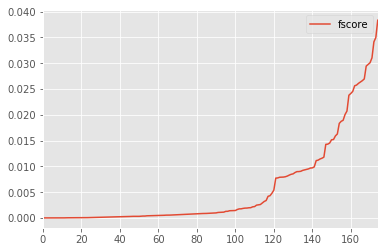

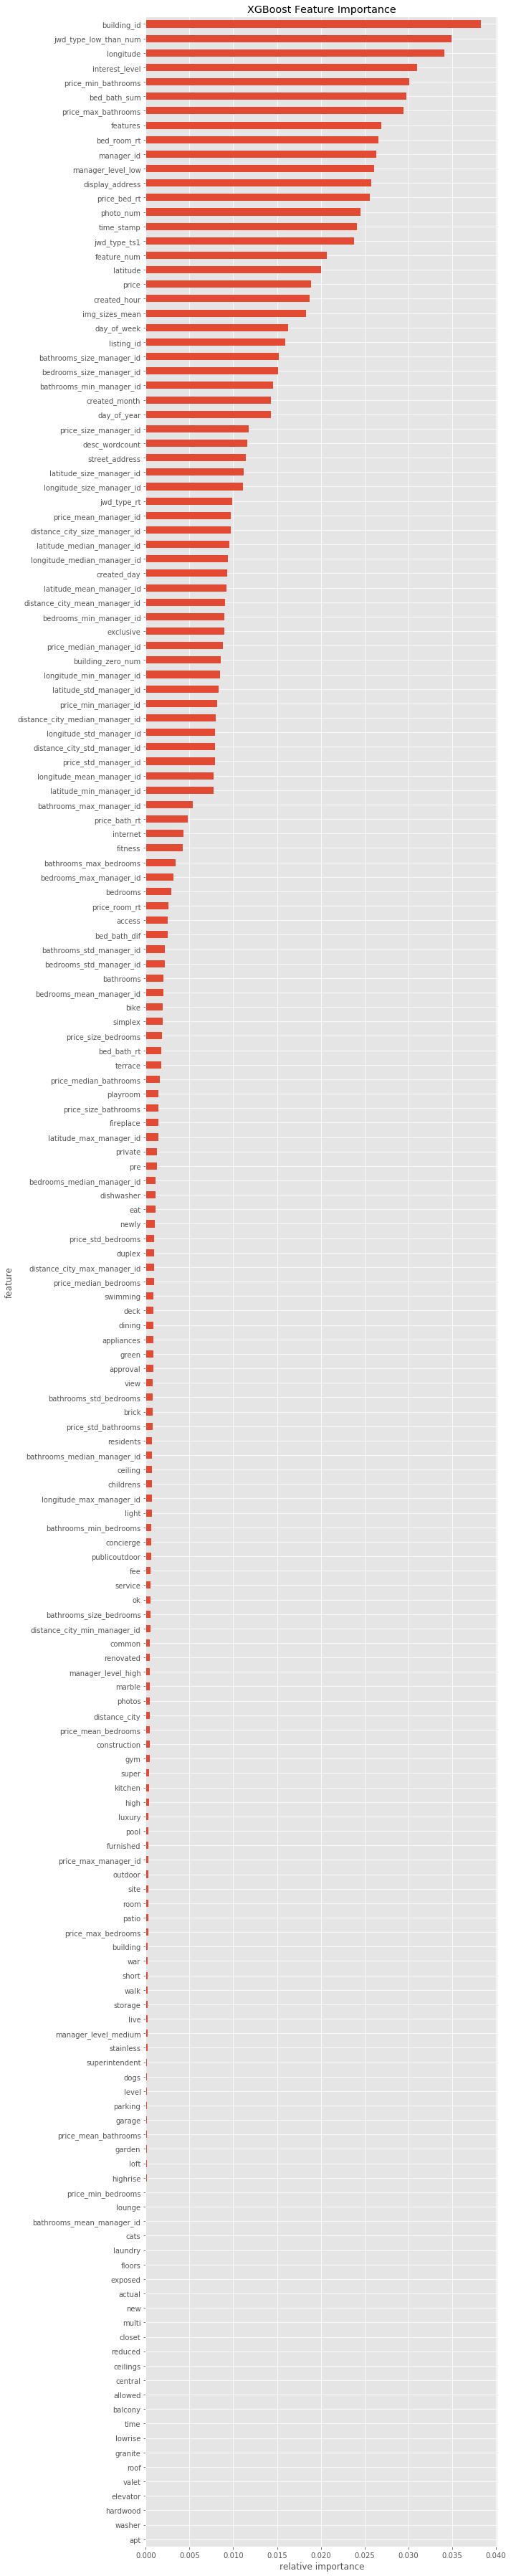

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(10, 50))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.tight_layout()
plt.gcf().savefig('output/feature_importance_xgb.eps', dpi=100)

In [11]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

In [12]:
print_full(df.sort_values(by='fscore', ascending=False))

                              feature    fscore
181                             price  0.038614
180                     price_room_rt  0.033639
179                     distance_city  0.028477
178                        listing_id  0.028373
177                        time_stamp  0.028044
176                          latitude  0.025803
175                       building_id  0.025608
174                   display_address  0.025205
173                    street_address  0.025078
172              manager_level_medium  0.023554
171                         longitude  0.022658
170                       feature_num  0.022389
169                 manager_level_low  0.020954
168                    img_sizes_mean  0.019991
167                     price_bath_rt  0.019610
166                      price_bed_rt  0.019557
165                manager_level_high  0.017899
164                    desc_wordcount  0.017638
163                       created_day  0.012154
162                       day_of_year  0

## Visualization using PCA

In [37]:
#print_full(x_train.isnull().sum())
#print_full(np.isinf(x_train).sum())
x_train = x_train.fillna(-1)
print(x_train.isnull().values.any())
x_train = x_train.replace(np.inf, -1)
print(np.isinf(x_train).values.any())

False
False


In [38]:
tr_dtm = pd.DataFrame(tr_sparse.toarray())
tr_dtm.columns = feature_dtm
print(tr_dtm.isnull().values.any())
print(np.isinf(tr_dtm).values.any())

False
False


In [79]:
df = pd.concat([x_train, (2-y_train).astype(object)], axis=1)
df.shape

(49352, 130)

In [72]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_res = pca.fit_transform(df.ix[:,:-1].values)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [ 0.96871455  0.0287027   0.00235001]


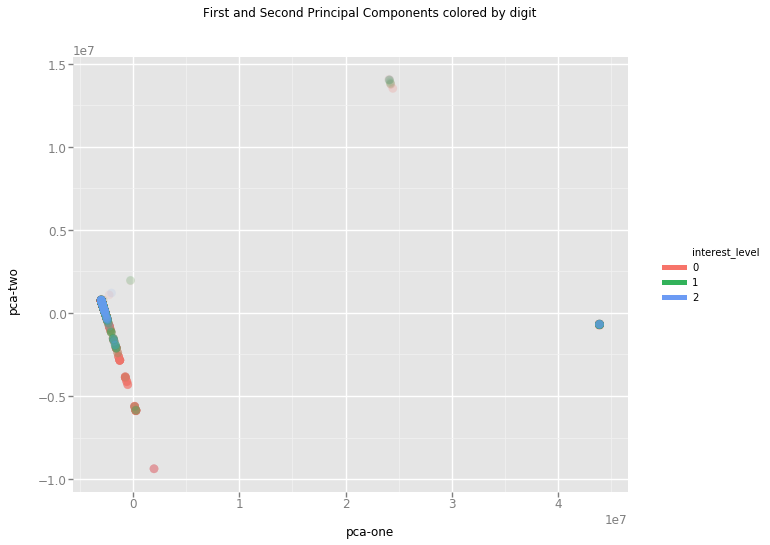

<ggplot: (8744765597546)>

In [83]:
from ggplot import *

df['pca-one'] = pca_res[:,0]
df['pca-two'] = pca_res[:,1] 
df['pca-three'] = pca_res[:,2]

chart = ggplot( df.loc[:3000,:], aes(x='pca-one', y='pca-two', color='interest_level') ) \
        + geom_point(size=75,alpha=0.1) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

## Visualizing with t-SNE 

In [68]:
import time
from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_res = tsne.fit_transform(df.ix[:n_sne,:-1].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 7001
[t-SNE] Computed conditional probabilities for sample 2000 / 7001
[t-SNE] Computed conditional probabilities for sample 3000 / 7001
[t-SNE] Computed conditional probabilities for sample 4000 / 7001
[t-SNE] Computed conditional probabilities for sample 5000 / 7001
[t-SNE] Computed conditional probabilities for sample 6000 / 7001
[t-SNE] Computed conditional probabilities for sample 7000 / 7001
[t-SNE] Computed conditional probabilities for sample 7001 / 7001
[t-SNE] Mean sigma: 25314.490396
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.342449
[t-SNE] Error after 300 iterations: 1.342449
t-SNE done! Time elapsed: 475.48483896255493 seconds


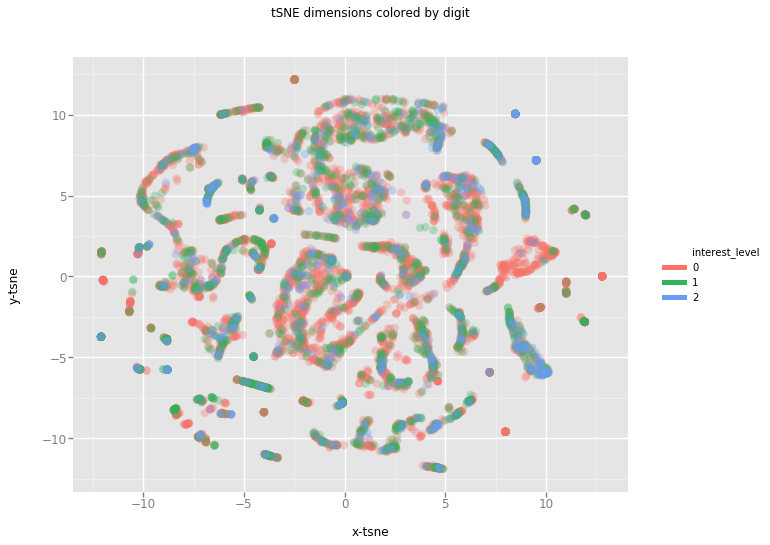

<ggplot: (-9223363292125576167)>

In [82]:
df_tsne = df.ix[:n_sne,:].copy()
df_tsne['x-tsne'] = tsne_res[:,0]
df_tsne['y-tsne'] = tsne_res[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='interest_level') ) \
        + geom_point(size=70,alpha=0.3) \
        + ggtitle("tSNE dimensions colored by digit")
chart

## Conclusion

Unfortunately, both PCA and t-SNE analysis does not lead to interesting plots of visualizing `interest-level` separated clusters.